Logistic Regression with L2 regularization

In [ ]:
pip install turicreate

Fire up Turi Create

In [15]:
from __future__ import division
import turicreate as tc

In [16]:
products = tc.SFrame('/content/drive/My Drive/amazon_baby_subset.sframe')
products

Columns:
	name	str
	review	str
	rating	float
	sentiment	int

Rows: 53072

Data:
+-------------------------------+-------------------------------+--------+-----------+
|              name             |             review            | rating | sentiment |
+-------------------------------+-------------------------------+--------+-----------+
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |     1     |
| Nature's Lullabies Second ... | We wanted to get something... |  5.0   |     1     |
| Nature's Lullabies Second ... | My daughter had her 1st ba... |  5.0   |     1     |
|  Lamaze Peekaboo, I Love You  | One of baby's first and fa... |  4.0   |     1     |
| SoftPlay Peek-A-Boo Where'... | Very cute interactive book... |  5.0   |     1     |
|   Our Baby Girl Memory Book   | Beautiful book, I love it ... |  5.0   |     1     |
| Hunnt&reg; Falling Flowers... | Try this out for a spring ... |  5.0   |     1     |
| Blessed By Pope Benedict X... | very nice Divine Mercy Pen... |  5.0   |     1     |
| Cloth Diaper Pins Stainles... | We bought the pins as my 6... |  4.0   |     1     |
| Cloth Diaper Pins Stainles... | It has been many years sin... |  5.0   |     1     |
+-------------------------------+-------------------------------+--------+-----------+
[53072 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Load and process review dataset

In [17]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('/content/drive/My Drive/important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

import string 
def remove_punctuation(text):
  translator = text.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  return text

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Train-Validation split

In [18]:
train_data, validation_data = products.random_split(.8, seed=2)

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42361 data points
Validation set : 10711 data points


Convert SFrame to NumPy array

In [19]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [20]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [21]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    predictions = []
    # Take dot product of feature_matrix and coefficients  
    scores  = np.dot(feature_matrix,coefficients)
    # Compute P(y_i = +1 | x_i, w) using the link function
    for value in scores:
      pred = 1/(1 + np.exp(-value))
      predictions.append(pred)
    
    # return predictions
    return predictions

Adding L2 penalty

In [23]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        derivative -= (2 * l2_penalty * coefficient)
        
    return derivative



In [24]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp



Logisic Regression With L2 penalty

In [27]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

Explore effects of L2 regularization

In [28]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [29]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [30]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [31]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [32]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [33]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

Compare coefficients

In [34]:
table = turicreate.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [36]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

Columns:
	word	str
	coefficients [L2=0]	float
	coefficients [L2=4]	float
	coefficients [L2=10]	float
	coefficients [L2=1e2]	float
	coefficients [L2=1e3]	float
	coefficients [L2=1e5]	float

Rows: 194

Data:
+-------------+-------------------------+-----------------------+
|     word    |   coefficients [L2=0]   |  coefficients [L2=4]  |
+-------------+-------------------------+-----------------------+
| (intercept) |   -0.06374213522751736  |  -0.06314308770737208 |
|     baby    |    0.0740730059216435   |  0.07399385414054363  |
|     one     |   0.012752505778363732  |  0.01249497044812448  |
|    great    |    0.8016249897781762   |   0.7968969330033088  |
|     love    |    1.0585539820695435   |   1.050855680993631   |
|     use     | -0.00010415219124811945 | 0.0001628576561772408 |
|    would    |   -0.28702144353429704  |  -0.2860272029746515  |
|     like    |  -0.0033844739929333313 | -0.003442085770451767 |
|     easy    |    0.9845588198731924   |   0.9776001497817036  |
|    little   |    0.5244194563643343   |   0.5213847261068162  |
+-------------+-------------------------+-----------------------+
+------------------------+-----------------------+------------------------+
|  coefficients [L2=10]  | coefficients [L2=1e2] | coefficients [L2=1e3]  |
+------------------------+-----------------------+------------------------+
|  -0.06225594377004484  |  -0.05043836519527793 | 5.3867532695823166e-05 |
|  0.07387735348036835   |  0.07236036022182919  |  0.05975168883639244   |
|  0.012115252953356623  |  0.00724728331869879  | -0.008760917620035742  |
|   0.7899351472214042   |   0.7014250736748336  |  0.37601171422167073   |
|   1.0395285158465861   |   0.8966441331010778  |   0.4183536441339269   |
| 0.0005557109757555857  |  0.005481032679461016 |  0.01732648744612427   |
|  -0.28456403556187243  |  -0.2659927462255519  |  -0.18866242204876657  |
| -0.0035272944496608154 | -0.004634992832527627 | -0.007043075843533989  |
|   0.9673618366314701   |   0.8382448329554505  |  0.40190397136319134   |
|   0.5169173924914707   |   0.4602345779024191  |   0.2512206539585926   |
+------------------------+-----------------------+------------------------+
+------------------------+
| coefficients [L2=1e5]  |
+------------------------+
|  0.011361751184438747  |
| 0.0017841492162980102  |
| -0.0018268556802280068 |
|  0.008949560497355635  |
|  0.009041737297695288  |
|  0.000417863934615973  |
| -0.008127027099004498  |
| -0.0008266502700305295 |
|  0.00880768121210408   |
|  0.005940513640376537  |
+------------------------+
[194 rows x 7 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [38]:
table[['word','coefficients [L2=0]']].sort('coefficients [L2=0]',ascending = False)

Columns:
	word	str
	coefficients [L2=0]	float

Rows: 194

Data:
+---------+---------------------+
|   word  | coefficients [L2=0] |
+---------+---------------------+
|   love  |  1.0585539820695435 |
|  loves  |  1.0524840477983537 |
|   easy  |  0.9845588198731924 |
| perfect |  0.8356932076383464 |
|  great  |  0.8016249897781762 |
|  happy  |  0.5573952023634463 |
|   best  |  0.535033889771777  |
|  little |  0.5244194563643343 |
|   fits  |  0.4876522532652972 |
|   well  |  0.4538664867675504 |
+---------+---------------------+
[194 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [39]:
positive_words = table.topk('coefficients [L2=0]',k=5,reverse=False)['word']


In [40]:
positive_words

dtype: str
Rows: 5
['love', 'loves', 'easy', 'perfect', 'great']

In [41]:
negative_words = table.topk('coefficients [L2=0]',k=5,reverse=True)['word']
negative_words

dtype: str
Rows: 5
['disappointed', 'money', 'return', 'waste', 'returned']

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to plot the coefficient path.

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

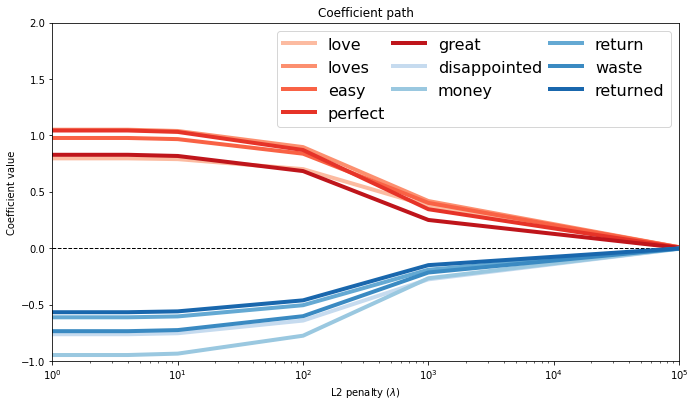

In [43]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

Measuring accuracy

In [44]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the training data and validation data for all the models that were trained in this assignment. We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [45]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [46]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7851561577866434, validation_accuracy = 0.781439641490057
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7851089445480512, validation_accuracy = 0.7815330034543927
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7849909114515711, validation_accuracy = 0.7817197273830642
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7839758268218409, validation_accuracy = 0.781066193632714
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6803663747314747, validation_accuracy = 0.667818130893474
-----------------------------

<function matplotlib.pyplot.tight_layout>

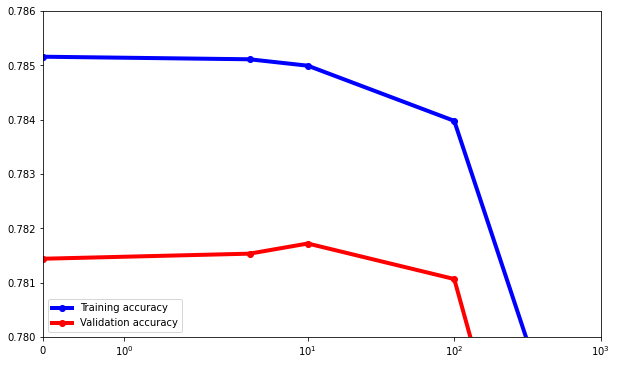

In [48]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout